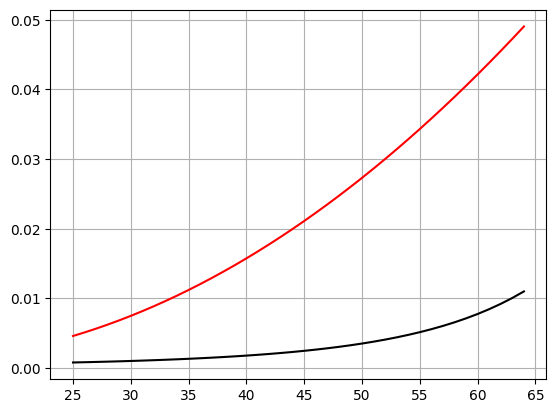

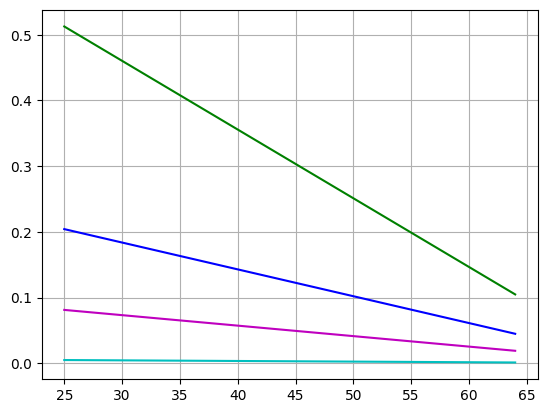

In [4]:
import numpy as np
import matplotlib.pyplot as plt

class Markov:
    def __init__(self):
        self.iNrStates = None
        self.iMaxTime  = None    
        self.dPij = [] # for each time a matrix ie dPij[k] matrix at time k
        self.dPre = [] # Vector vector of annuities at time t
        self.dPost= []
        self.dv   = []
        # Outputs
        self.dDK  = []
        self.dDKDistr  = []
        self.dCF  = []
        self.bCalculated = False
        self.bCFCalculated = False
        self.bCalculatedDistr = False
        self.iStart = None
        self.iStop  = None
        self.fDistrLow = -1000
        self.fDistrHigh = 150000
        self.iNrBuckets = 10000
        self.fBucketWidth = (self.fDistrHigh-self.fDistrLow)/self.iNrBuckets
        self.fBucketWidthRound = self.fBucketWidth / 2.
                
    def vDefineModel(self,iNrStates,iMaxTime=1200):
        self.iNrStates = iNrStates
        self.iMaxTime = iMaxTime
        for i in range(iMaxTime):
            tempPij = np.zeros([iNrStates,iNrStates])
            tempPost = np.zeros([iNrStates,iNrStates])
            tempPre = np.zeros([iNrStates])
            tempDK = np.zeros([iNrStates])
            tempCF = np.zeros([iNrStates])
            self.dPij.append(tempPij)
            self.dPost.append(tempPost)
            self.dPre.append(tempPre)
            self.dDK.append(tempDK)
            self.dCF.append(tempCF)  
        tempv = np.zeros([iMaxTime])
        self.dv=tempv
        
    def iBucketNr(self, fValue):
        if fValue < self.fDistrLow:
            return(0)
        iBNR = (int(min(self.iNrBuckets-1,(fValue-self.fDistrLow)/self.fBucketWidth+self.fBucketWidthRound)))
        return(iBNR)
    
    def fValueOfBucket(self, iBucket):
        return(self.fBucketWidth*min(self.iNrBuckets-1,iBucket)+self.fDistrLow)
    
    def vCreateDistModel(self):
        print("You Know that you can call me only once everything is done")
        for i in range(self.iMaxTime):
            tempDK = np.zeros([self.iNrStates,self.iNrBuckets])
            self.dDKDistr.append(tempDK)
    
    def vSetDiscount(self,fIRate):# you set v
        vTemp = 1./(1.+fIRate)
        for i in range(self.iMaxTime):
            self.dv[i] = vTemp
        self.bCalculated = False
        self.bCFCalculated = False
    
    def vSetPij(self,t,i,j,fValue):# you set p_{ij}(t,t+1)
        self.dPij[t][i,j] = fValue
        self.bCalculated = False
        self.bCFCalculated = False
    
    def vSetPre(self,t,i,j,fValue):# you set a_{i}^{pre}(t) 
        self.dPre[t][i] = fValue
        self.bCalculated = False
        self.bCFCalculated = False
    
    def vSetPost(self,t,i,j,fValue):# you set a_{ij}^{post}(t)
        self.dPost[t][i,j] = fValue
        self.bCalculated = False
        self.bCFCalculated = False

    def doComplementStates(self,default=None, eps = 0.0001):
        iState = self.iNrStates -1
        if default != None:
            iState = default
        for i in range(self.iNrStates):
            bFound = False
            for t in range(self.iStop,self.iStart):
                fTot = sum(self.dPij[t][i,:])
                #print(i,t,"-->",fTot)
                if abs(fTot-1.) >= eps:
                    bFound=True
                    self.dPij[t][i,default] += 1. - fTot
            if bFound:
                print("Check P(Omega) = 1 failed for iState=",i,"Target State",iState)

    
    def doCalculateDK(self,iStart,iStop,iAge,iState):
        self.iStop = iStop
        self.iStart = iStart
        self.bCalculated = True
        for i in range(self.iMaxTime):
            self.dDK[i] *= 0.
        
        for i in range(self.iStart-1, self.iStop-1,-1):
            #print("Calc Time", i)
            for j in range(self.iNrStates):
                self.dDK[i][j] = self.dPre[i][j]
                for k in range(self.iNrStates):
                    self.dDK[i][j] += self.dv[i]*self.dPij[i][j,k]*(self.dPost[i][j,k]+self.dDK[i+1][k])

    def doCalculateCF(self,iStart,iStop,iAge,iState,bTrace=False):
        self.iStop = iStop
        self.iStart = iStart
        self.bCFCalculated = True
        for i in range(self.iMaxTime):
            self.dCF[i] *= 0.
        
        CurrentP = np.asmatrix(np.identity(self.iNrStates))
        if bTrace:
            print("----- ----- ----- ----- ")
        for i in range(self.iStop, self.iStart):
            if bTrace:
                print("----- ----- ----- ----- ")
                print(" Time ", i)
                print("CF BoP", self.dCF[i])
            for k in range(self.iNrStates):
                for l in range(self.iNrStates):
                    self.dCF[i][k] += CurrentP[k,l] * self.dPre[i][l]
            if bTrace:
                print("CF BoP after Pre", self.dCF[i])
            NextP = np.asmatrix(self.dPij[i])
            if bTrace:
                print("+++++ +++++ +++++ ")
                print("CurrentP\n", CurrentP) 
                print("+++++ +++++ +++++ ")
                print("Next P\n", NextP) 
                print("+++++ +++++ +++++ ")
                
            for k in range(self.iNrStates):
                for l in range(self.iNrStates):
                    for m in range(self.iNrStates):
                        self.dCF[i+1][k] += CurrentP[k,l] * NextP[l,m] * self.dPost[i][l,m]
            if bTrace:
                print("CF EoP t", self.dCF[i])
                print("CF EoP t+1", self.dCF[i+1])
            
            CurrentP = CurrentP * NextP # This is Chapman Kolmogorov
            if bTrace:
                print("+++++ +++++ +++++ ")
                print("CurrentP EoP\n", CurrentP) 
                print("+++++ +++++ +++++ ")

    def doCalculateDKDistr(self,iStart,iStop,iAge,iState,default=None):
        self.iStop = iStop
        self.iStart = iStart
        self.bCalculatedDistr = True
        self.vCreateDistModel()
        print("default is",str(default))
        self.doComplementStates(default=default)
        for i in range(self.iMaxTime):
            self.dDKDistr[i] *= 0.
        # Set Boundary Conditions
        iIndexSwitch = self.iBucketNr(0)
        for j in range(self.iNrStates):
            value = 0.
            for l in range(self.iNrBuckets):
                if l > iIndexSwitch:
                           value = 1.
                self.dDKDistr[self.iStart][j,l] = value
        # Calculation                   
        for i in range(self.iStart-1, self.iStop-1,-1):
            print("Dirst DK Calc Time", i)
            for j in range(self.iNrStates):
                for k in range(self.iNrStates):
                    for l in range(self.iNrBuckets):
                        dNewXTPlusOne = (self.fValueOfBucket(l) - self.dPre[i][j])/self.dv[i] - self.dPost[i][j,k]
                        self.dDKDistr[i][j,l] += self.dPij[i][j,k]*(self.dDKDistr[i+1][k,self.iBucketNr(dNewXTPlusOne)])
                                      
    
    def dGetDK(self,iStart,iStop,iAge,iState):
        if (iStart != self.iStart or iStop != self.iStop or not(self.bCalculated)):
            self.doCalculateDK(iStart,iStop,iAge,iState)
        return(self.dDK[iAge][iState])

    def dGetCF(self,iStart,iStop,iAge,iState):
        if (not(self.bCFCalculated) or self.iStart != iStart or self.iStop != iStop ):
            self.doCalculateCF(iStart,iStop,iAge,iState)
        return(self.dCF[iAge][iState])
    
    def dGetDKDistr(self,iStart,iStop,iAge,iState,fValue,default=None):
        if (iStart != self.iStart or iStop != self.iStop or not(self.bCalculatedDistr)):
            temp = self.dGetDK(iStart,iStop,iAge,iState) # To be on the safe side
            self.doCalculateDKDistr(iStart,iStop,iAge,iState,default=default)
        return(self.dDKDistr[iAge][iState,self.iBucketNr(fValue)])
    
    def PrintDKs(self,iStart,iStop):
        for i in range(iStop,iStart+1):
            strTemp = " %3d :"%(i)
            for j in range(self.iNrStates):
                 strTemp += "  %7.4f "%(self.dGetDK(iStart,iStop,i,j))
            print(strTemp)
    
    def PlotDKs(self,iStart,iStop,figNr=1):
        x = []
        y = []
        for i in range(iStop,iStart+1):
            x.append(i)
            ytemp = np.zeros(self.iNrStates)
            for j in range(self.iNrStates):
                ytemp[j] = self.dGetDK(iStart,iStop,i,j)
            y.append(ytemp)
        plt.figure(figNr)
        plt.plot(x,y)
        plt.grid(True)

    def PlotCFs(self,iStart,iStop,figNr=2,bLines=True):
        import matplotlib.colors as mcolors
        if bLines:
            x=[]
            y=[]
            plt.figure(figNr)
                
            for j in range(self.iNrStates):
                x=[]
                y=[]
                for i in range(iStop,iStart+1):
                    x.append(i)
                    y.append(self.dGetCF(iStart,iStop,i,j))
                plt.plot(x,y)
            plt.grid(True)
        else:
            A= []
            for i in mcolors.TABLEAU_COLORS.keys():
                A.append(i)
            for i in mcolors.BASE_COLORS.keys():
                A.append(i)
        
            xBar =[]
            hBar =[]
            bBar =[]
            cBar =[]
            y = []
            for i in range(iStop,iStart+1):
                for j in range(self.iNrStates):
                    xBar.append(i+(j)*1./self.iNrStates)
                    hBar.append(self.dGetCF(iStart,iStop,i,j))
                    bBar.append(0)
                    cBar.append(A[j])
            
            plt.figure(figNr)
            plt.bar(xBar,hBar,bottom=bBar, width = 1./self.iNrStates,color=cBar)
            plt.grid(True)
    
    def PlotDKDistr(self,iStart,iStop, iSteps = None, iStates = [0], iDeltaT = 5, figNr=10, eps = 0.01,legTitle="",default=None):
        if iSteps == None:
            iSteps = []
            for i in range(iStop,iStart,iDeltaT):
                iSteps.append(i)
            iSteps.append(iStart)
        for i in iSteps:
            for j in iStates:
                x = []
                y = []
                for k in range(self.iNrBuckets):
                    xLoc = eps + self.fValueOfBucket(k)
                    yLoc = self.dGetDKDistr(iStart,iStop,i,j,xLoc,default=default)
                    x.append(xLoc)
                    y.append(yLoc)
    
                plt.figure(figNr)
                plt.plot(x,y)
                plt.grid(True)
                mylegend = legTitle + "Age %d - State %d"%(i,j)
                plt.title(mylegend)
                figNr+=1
        

def mua(x): # mortality as active
    return(np.exp(-7.85785 + 0.01538*x + 0.000577355*x**2))

def mui(x): # moryality as disabled
    return(mua(x)+0.008)

def sigma(x): # ix
    return(3.e-4 * (8.4764-1.0985*x + 0.055*x**2))

def alpha(x,k):
    return(0.773763-0.01045*(x-k + 1))

def rx(x,k,n=8):
    if (k>= n): return(0.)
    return(np.exp(-0.94*(k-1)) * alpha(x, k))



x=[]
ix =[]
qx=[]
rxv=[]
rxv1=[]
rxv2=[]
rxv5=[]

for i in range(25,65):
    x.append(i)
    qx.append(mua(i))
    ix.append(sigma(i))
    rxv.append(rx(i,1))
    rxv2.append(rx(i,3))
    rxv1.append(rx(i,2))
    rxv5.append(rx(i,6))

plt.figure(1)
plt.plot(x,qx,"k",x,ix,'r')
plt.grid(True)


plt.figure(2)
plt.plot(x,rxv,'g',x,rxv1,'b',x,rxv2,'m',x,rxv5,'c')
plt.grid(True)


    

  30 :  9852.2288   8396.2132   95669.3762   155750.9118   184601.5093   196972.5646   202071.2746   204153.8287   205015.8107    0.0000 
  31 :  10251.9790   10906.4823   96878.0681   155071.9380   182897.7772   194815.8414   199727.4995   201734.4842   202565.8984    0.0000 
  32 :  10650.6342   13458.6725   97998.2385   154282.1642   181082.0641   192547.9585   197273.0521   199204.6622   200005.5727    0.0000 
  33 :  11044.8334   16042.4764   99021.2285   153375.0328   179148.7888   190163.7346   194702.9094   196559.4021   197329.8973    0.0000 
  34 :  11430.8630   18646.7086   99937.9506   152343.6910   177092.1175   187657.7506   192011.8165   193793.5135   194533.7069    0.0000 
  35 :  11804.6641   21259.3076   100738.8934   151180.9871   174905.9543   185024.3380   189194.2739   190901.5630   191611.5943    0.0000 
  36 :  12161.8438   23867.3412   101414.1266   149879.4656   172583.9311   182257.5663   186244.5236   187877.8605   188557.8962    0.0000 
  37 :  12497.6922  

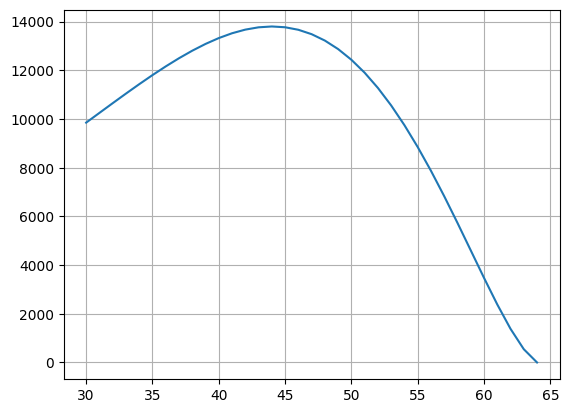

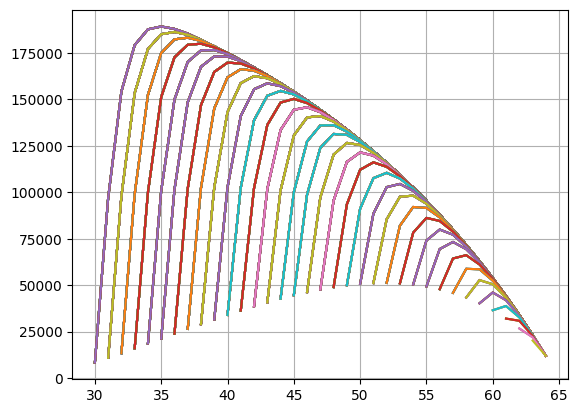

In [5]:
x0 = 30
s  = 65
iRate = 0.04
Annuity = 12000

iStart = s
iStop = x0

symM = Markov()
symM.vDefineModel(8+2) # *, t plus 8 disabled
symM.vSetDiscount(iRate)

for i in range(iStop,iStart):
    symM.vSetPij(i,0,0, 1. - sigma(i) - mua(i)) # 0 -- *
    symM.vSetPij(i,0,1, sigma(i)) # 1 -- D_1
    symM.vSetPij(i,0,9, mua(i)) # 9 -- t
    for j in range(8):
        if j<7: # not absorbing
            symM.vSetPij(i,1+j,1+j+1, 1.- mui(i)- rx(i,j))
            symM.vSetPij(i,1+j,0, rx(i,j))
           
        else:
            symM.vSetPij(i,8,8, 1.- mui(i))
        symM.vSetPij(i,1+j,9, mui(i))
        # benefit
        symM.vSetPre(i,1+j,1+j,Annuity)
        

x = []
y = []

for i in range(iStop,iStart):
    x.append(i)
    y.append(symM.dGetDK(iStart,iStop,i,0))
    
plt.figure(1)
plt.plot(x,y)
plt.grid(True)

plt.figure(2)
for i in range(iStop,iStart):
    x = []
    y = []
    for j in range(i,iStart):
        x.append(j)
        state = min(8,1+(j-i))
        y.append(symM.dGetDK(iStart,iStop,j,state))
        plt.plot(x,y)
plt.grid(True)
        

symM.PrintDKs(iStart,iStop)
    

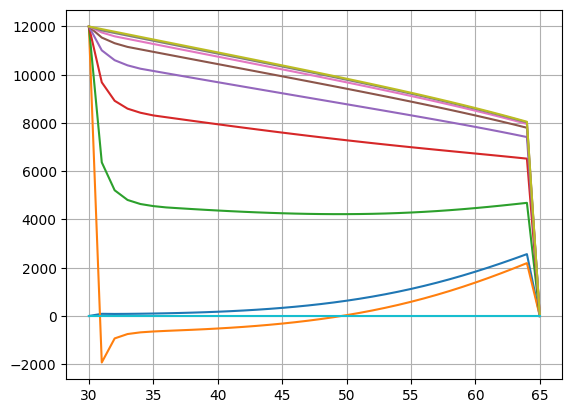

In [6]:
symM.PlotCFs(iStart,iStop)